# Analyzing NASA Data with Dask

## Create cluster on AWS

_This cell is all that's needed to run this analysis on a cluster_

In [1]:
%%time

# Spin up a Coiled cluster in region us-west-2
import coiled

cluster = coiled.Cluster(n_workers=20, region="us-west-2")
client = cluster.get_client()

ModuleNotFoundError: No module named 'coiled'

## Get data files with `earthaccess`

In [2]:
# Authenticate my machine with `earthaccess`
import earthaccess

earthaccess.login();

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 08/04/2023
Using environment variables for EDL


In [3]:
# Define region bounding box
lon0, lat0 = -124.5, 36.5
dlon, dlat = 2.5, 2.0 # half of box width in lon/lat
lon_min, lon_max = lon0 - dlon, lon0 + dlon
lat_min, lat_max = lat0 - dlat, lat0 + dlat

bounding_box = (lon_min, lat_min, lon_max, lat_max)

In [4]:
# Retrieve data files for the dataset I'm interested in
results = earthaccess.search_data(
    short_name="VIIRS_NPP-STAR-L3U-v2.80",
    concept_id="C2147485059-POCLOUD",
    cloud_hosted=True,
    bounding_box=bounding_box,
    temporal=("2021-04-01", "2021-05-6"),
    count=30, # For demo purposes
)

Granules found: 196


## Analyze data on my cluster with Xarray

In [5]:
%%time

# Open data files with Xarray

import xarray as xr

ds = xr.open_mfdataset(earthaccess.open(results))
ds

 Opening 30 granules, approx size: 0.0 GB


SUBMITTING | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 7.73 s, sys: 1.43 s, total: 9.16 s
Wall time: 44.3 s


<xarray.Dataset>
Dimensions:                  (lon: 18000, lat: 9000, time: 30)
Coordinates:
  * lon                      (lon) float32 -180.0 -180.0 -179.9 ... 180.0 180.0
  * lat                      (lat) float32 89.99 89.97 89.95 ... -89.97 -89.99
  * time                     (time) datetime64[ns] 2021-04-01T08:10:01 ... 20...
Data variables: (12/13)
    quality_level            (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    l2p_flags                (time, lat, lon) int16 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    or_number_of_pixels      (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    dt_analysis              (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    satellite_zenith_angle   (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    ...                       ...
    sses_standard_deviation  (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    wind_speed               (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    sst_dtime                (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    crs                      (time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sst_gradient_magnitude   (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
    sst_front_position       (time, lat, lon) float32 dask.array<chunksize=(1, 9000, 18000), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                Conventions = CF-1.7, ACDD-1.3
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    SSTs are a weighted average of the SSTs of co...
    creator_email:              Alex.Ignatov@noaa.gov
    creator_name:               Alex Ignatov
    ...                         ...
    col_start:                  2879
    col_count:                  3875
    l3u_bias_subskin_night:     0.034
    l3u_bias_subskin_day:       0.018
    l3u_bias_depth_night:       0.01
    l3u_bias_depth_day:         0.012

CPU times: user 266 ms, sys: 71.1 ms, total: 337 ms
Wall time: 35 s


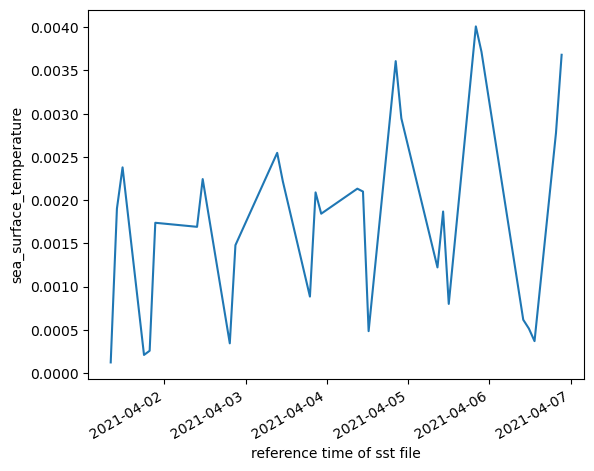

In [7]:
%%time

# Compute and plot some results from the dataset

result = ds.sea_surface_temperature.notnull().mean({'lon','lat'}).compute()
result.plot();